# IndiaAI Face Authentication Challenge – Prototype

Privacy-preserving face de-duplication pipeline with quality, liveness, cancelable templates, and two-stage matching.


## 1. Setup and Imports

Run the optional installation cell when preparing a fresh environment, then execute the consolidated import cell.


In [1]:
# Optional: install dependencies for a new environment
# !pip install -r requirements_indiaai.txt


In [2]:
import os
import io
import json
import uuid
import time
import math
import tarfile
import urllib.request
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.feature import local_binary_pattern
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, fftshift
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.random_projection import GaussianRandomProjection

try:
    import face_recognition
except ImportError as exc:
    raise ImportError("face_recognition is required. Install via `pip install face_recognition dlib`. ") from exc

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)


## 2. System Configuration


In [3]:
class Config:
    """Centralised configuration with thresholds and storage paths."""

    TEMPLATE_KEY = os.urandom(32)
    HASH_SECRET = os.urandom(16)
    EMBEDDING_DIM = 128
    CANCELABLE_DIM = 256

    LSH_NUM_TABLES = 16
    LSH_NUM_BITS = 12
    MAX_CANDIDATES_PER_QUERY = 100

    MATCH_THRESHOLD_HIGH = 0.82
    MATCH_THRESHOLD_LOW = 0.55

    MIN_FACE_SIZE = 80
    MAX_BLUR_SCORE = 100
    LIVENESS_THRESHOLD = 0.2

    DATA_DIR = Path("./face_dedup_data")
    AUDIT_LOG_PATH = DATA_DIR / "audit_logs.jsonl"
    LFW_URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"

    def __init__(self):
        self.DATA_DIR.mkdir(exist_ok=True)
        self.AUDIT_LOG_PATH.touch(exist_ok=True)

config = Config()
print(f"✓ Config loaded | data dir: {config.DATA_DIR}")


✓ Config loaded | data dir: face_dedup_data


## 3. Image Quality Assessment


In [4]:
class QualityAssessment:
    """Assesses blur, pose, and lighting to gate low-quality images."""

    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    def detect_blur(self, image: np.ndarray) -> float:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        return cv2.Laplacian(gray, cv2.CV_64F).var()

    def estimate_pose(self, image: np.ndarray) -> Dict[str, float]:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)
        if len(faces) == 0:
            return {"yaw": 0.0, "roll": 0.0, "quality": "poor"}
        x, y, w, h = faces[0]
        roi = gray[y:y+h, x:x+w]
        eyes = self.eye_cascade.detectMultiScale(roi, scaleFactor=1.1, minNeighbors=3)
        if len(eyes) >= 2:
            eyes = sorted(eyes[:2], key=lambda e: e[0])
            (x1, y1, w1, h1), (x2, y2, w2, h2) = eyes
            left_center = (x1 + w1 / 2, y1 + h1 / 2)
            right_center = (x2 + w2 / 2, y2 + h2 / 2)
            dx = right_center[0] - left_center[0]
            dy = right_center[1] - left_center[1]
            roll = np.degrees(np.arctan2(dy, dx))
            expected = w * 0.42
            yaw = ((dx - expected) / expected) * 25.0
            return {"yaw": abs(yaw), "roll": abs(roll), "quality": "good"}
        return {"yaw": 15.0, "roll": 10.0, "quality": "moderate"}

    def lighting_stats(self, image: np.ndarray) -> Dict[str, float]:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        mean = float(np.mean(gray))
        std = float(np.std(gray))
        over = float(np.mean(gray > 245))
        under = float(np.mean(gray < 15))
        quality = "good" if 40 < mean < 210 and over < 0.05 and under < 0.05 else "poor"
        return {"mean": mean, "std": std, "over": over, "under": under, "quality": quality}

    def comprehensive(self, image: np.ndarray) -> Dict[str, object]:
        blur = self.detect_blur(image)
        pose = self.estimate_pose(image)
        lighting = self.lighting_stats(image)
        score = 0
        score += 40 if blur > 500 else 20 if blur > 150 else 10
        score += 30 if pose['quality'] == 'good' else 15
        score += 30 if lighting['quality'] == 'good' else 15
        decision = 'ACCEPT' if score >= 70 else 'MANUAL_REVIEW' if score >= 50 else 'REJECT'
        return {
            'quality_score': score,
            'decision': decision,
            'blur': blur,
            'pose': pose,
            'lighting': lighting
        }

qa = QualityAssessment()
print('✓ Quality module ready')


✓ Quality module ready


## 4. Cancelable Biometric Templates


In [5]:
class CancelableBiometricTemplate:
    """Generates privacy-preserving templates via keyed random projections."""

    def __init__(self, key: bytes, input_dim: int, output_dim: int):
        rng = np.random.default_rng(int.from_bytes(key[:8], 'little'))
        self.projector = GaussianRandomProjection(n_components=output_dim, random_state=rng.integers(1, 1_000_000))
        self.input_dim = input_dim

    def fit(self, samples: np.ndarray):
        self.projector.fit(samples)

    def transform(self, embedding: np.ndarray) -> np.ndarray:
        proj = self.projector.transform(embedding.reshape(1, -1))[0]
        return proj.astype(np.float32)

cancelable = CancelableBiometricTemplate(config.TEMPLATE_KEY, config.EMBEDDING_DIM, config.CANCELABLE_DIM)
print('✓ Cancelable template generator ready')


✓ Cancelable template generator ready


## 5. LSH-Based Candidate Retrieval (Stage A)


In [6]:
class LSHFaceHashIndex:
    """Keyed multi-table LSH for fast candidate search."""

    def __init__(self, dim: int, num_tables: int, num_bits: int):
        self.dim = dim
        self.num_tables = num_tables
        self.num_bits = num_bits
        self.planes = np.random.default_rng(42).normal(size=(num_tables, num_bits, dim)).astype(np.float32)
        self.tables: List[Dict[str, List[str]]] = [dict() for _ in range(num_tables)]
        self.metadata: Dict[str, dict] = {}

    def _hash(self, vector: np.ndarray, table_idx: int) -> str:
        dots = self.planes[table_idx] @ vector
        bits = (dots > 0).astype(int)
        return ''.join(bits.astype(str))

    def insert(self, item_id: str, vector: np.ndarray, metadata: dict):
        self.metadata[item_id] = metadata
        for idx in range(self.num_tables):
            bucket = self._hash(vector, idx)
            self.tables[idx].setdefault(bucket, []).append(item_id)

    def query(self, vector: np.ndarray, max_candidates: int) -> List[Tuple[str, float]]:
        candidates = set()
        for idx in range(self.num_tables):
            bucket = self._hash(vector, idx)
            candidates.update(self.tables[idx].get(bucket, []))
        if not candidates:
            return []
        vec = vector.reshape(1, -1)
        cand_vectors = [self.metadata[c]['template'] for c in candidates if 'template' in self.metadata[c]]
        if not cand_vectors:
            return []
        mat = np.stack(cand_vectors, axis=0)
        sims = cosine_similarity(vec, mat)[0]
        ranked = sorted(zip(candidates, sims), key=lambda t: t[1], reverse=True)
        return ranked[:max_candidates]

lsh_index = LSHFaceHashIndex(config.CANCELABLE_DIM, config.LSH_NUM_TABLES, config.LSH_NUM_BITS)
print('✓ LSH index initialised')


✓ LSH index initialised


## 6. Deep Face Matching (Stage B)


In [7]:
class DeepFaceEmbedding:
    """Wraps face_recognition embeddings with cosine scoring."""

    def __init__(self):
        self.model_name = 'dlib-resnet'
        self.embedding_dim = config.EMBEDDING_DIM

    def extract(self, image: np.ndarray) -> Optional[np.ndarray]:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.ndim == 3 else image
        boxes = face_recognition.face_locations(rgb, model='hog')
        if not boxes:
            return None
        enc = face_recognition.face_encodings(rgb, boxes)
        return enc[0].astype(np.float32)

    def compare(self, a: np.ndarray, b: np.ndarray) -> float:
        return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8))

face_embedder = DeepFaceEmbedding()
print('✓ Deep embedding module ready')


✓ Deep embedding module ready


## 7. Passive Liveness Detection


In [8]:
class PassiveLivenessDetector:
    """Texture, spectral, and noise cues to detect spoofing."""

    def __init__(self, threshold: float):
        self.threshold = threshold

    def texture_score(self, image: np.ndarray) -> float:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp, bins=np.arange(60), density=True)
        entropy = -np.sum(hist * np.log(hist + 1e-8))
        return float(entropy / np.log(len(hist)))

    def frequency_score(self, image: np.ndarray) -> float:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        fft_mag = np.abs(fftshift(fft2(gray)))
        center = gaussian_filter(fft_mag, sigma=3)
        high_freq = fft_mag - center
        return float(np.mean(high_freq))

    def assess(self, image: np.ndarray) -> Dict[str, float]:
        texture = self.texture_score(image)
        spectral = self.frequency_score(image)
        composite = 0.6 * texture + 0.4 * (spectral / (spectral + 1e-6))
        decision = 'LIVE' if composite >= self.threshold else 'SPOOF'
        return {
            'texture': texture,
            'spectral': spectral,
            'score': composite,
            'decision': decision
        }
liveness_detector = PassiveLivenessDetector(config.LIVENESS_THRESHOLD)
print('✓ Liveness module ready')
print('✓ Liveness module ready')


✓ Liveness module ready
✓ Liveness module ready


## 8. Audit Logging


In [9]:
class AuditLogger:
    """JSONL audit trail with convenience methods."""

    def __init__(self, path: Path):
        self.path = path

    def log(self, record: dict):
        with self.path.open('a', encoding='utf-8') as fh:
            fh.write(json.dumps(record) + '\n')

audit_logger = AuditLogger(config.AUDIT_LOG_PATH)
print(f"✓ Audit logger ready at {config.AUDIT_LOG_PATH}")


✓ Audit logger ready at face_dedup_data/audit_logs.jsonl


## 9. End-to-End Face Deduplication Pipeline


In [10]:
class FaceDeduplicationPipeline:
    """Per-application processing with quality, liveness, LSH, and deep matching."""

    def __init__(self):
        self.qa = qa
        self.liveness = liveness_detector
        self.embedding = face_embedder
        self.cancelable = cancelable
        self.lsh = lsh_index
        self.audit = audit_logger
        self.applications: Dict[str, dict] = {}
        self.embeddings: Dict[str, np.ndarray] = {}
        self.template_ready = False
        self.stats = {
            'total': 0,
            'accepted': 0,
            'duplicates': 0,
            'manual_review': 0,
            'quality_reject': 0,
            'liveness_reject': 0
        }

    def _ensure_template_basis(self, embedding: np.ndarray):
        if not self.template_ready:
            samples = np.stack([embedding + np.random.normal(0, 0.01, size=embedding.shape) for _ in range(32)], axis=0)
            self.cancelable.fit(samples)
            self.template_ready = True

    def process(self, image: np.ndarray, metadata: dict) -> dict:
        app_id = str(uuid.uuid4())
        start = time.time()
        self.audit.log({'event': 'application_received', 'application_id': app_id, 'metadata': metadata})
        self.stats['total'] += 1

        quality = self.qa.comprehensive(image)
        self.audit.log({'event': 'quality', 'application_id': app_id, 'quality': quality})
        if quality['decision'] == 'REJECT':
            self.stats['quality_reject'] += 1
            return {'application_id': app_id, 'status': 'REJECTED_QUALITY', 'quality': quality}

        liveness = self.liveness.assess(image)
        self.audit.log({'event': 'liveness', 'application_id': app_id, 'liveness': liveness})
        if liveness['decision'] == 'SPOOF':
            self.stats['liveness_reject'] += 1
            return {'application_id': app_id, 'status': 'REJECTED_LIVENESS', 'quality': quality, 'liveness': liveness}

        embedding = self.embedding.extract(image)
        if embedding is None:
            self.stats['quality_reject'] += 1
            return {'application_id': app_id, 'status': 'REJECTED_NO_FACE', 'quality': quality}

        self._ensure_template_basis(embedding)
        template = self.cancelable.transform(embedding)

        candidates = self.lsh.query(template, max_candidates=config.MAX_CANDIDATES_PER_QUERY)
        matches = []
        for candidate_id, stage_a_score in candidates:
            cand_embed = self.embeddings.get(candidate_id)
            if cand_embed is None:
                continue
            stage_b = self.embedding.compare(embedding, cand_embed)
            combined = 0.3 * stage_a_score + 0.7 * stage_b
            matches.append({
                'application_id': candidate_id,
                'stage_a': float(stage_a_score),
                'stage_b': float(stage_b),
                'combined': float(combined),
                'metadata': self.applications.get(candidate_id, {})
            })
        matches.sort(key=lambda m: m['combined'], reverse=True)

        decision = self._decide(matches, quality, liveness)
        self.audit.log({'event': 'decision', 'application_id': app_id, 'decision': decision})

        if decision['decision'] == 'UNIQUE':
            self.applications[app_id] = metadata
            self.embeddings[app_id] = embedding
            self.lsh.insert(app_id, template, {'metadata': metadata, 'template': template})
            self.stats['accepted'] += 1
        elif decision['decision'] == 'DUPLICATE':
            self.stats['duplicates'] += 1
        else:
            self.stats['manual_review'] += 1

        duration = time.time() - start
        return {
            'application_id': app_id,
            'status': decision['decision'],
            'quality': quality,
            'liveness': liveness,
            'decision': decision,
            'matches': matches[:5],
            'processing_time': duration
        }

    def _decide(self, matches: List[dict], quality: dict, liveness: dict) -> dict:
        if not matches:
            return {'decision': 'UNIQUE', 'confidence': 1.0, 'reason': 'No similar applications located'}
        top = matches[0]
        score = top['combined']
        quality_factor = min(1.0, quality['quality_score'] / 100)
        liveness_factor = min(1.0, liveness['score'])
        adjust_high = config.MATCH_THRESHOLD_HIGH * (0.5 + 0.5 * quality_factor * liveness_factor)
        adjust_low = config.MATCH_THRESHOLD_LOW * (0.5 + 0.5 * quality_factor * liveness_factor)
        if score >= adjust_high:
            return {'decision': 'DUPLICATE', 'confidence': score, 'reason': f'similarity {score:.2f}', 'matches': matches[:3]}
        if score <= adjust_low:
            return {'decision': 'UNIQUE', 'confidence': 1 - score, 'reason': f'similarity {score:.2f} below threshold'}
        return {'decision': 'MANUAL_REVIEW', 'confidence': 0.5, 'reason': 'Ambiguous similarity', 'matches': matches[:3]}

    def get_stats(self) -> dict:
        total = max(1, self.stats['total'])
        return {
            **self.stats,
            'acceptance_rate': self.stats['accepted'] / total,
            'duplicate_rate': self.stats['duplicates'] / total,
            'manual_review_rate': self.stats['manual_review'] / total
        }


pipeline = FaceDeduplicationPipeline()
print('✓ Pipeline assembled')


✓ Pipeline assembled


## 10. Dataset Preparation


In [11]:
def download_lfw(target_dir: Path) -> Path:
    target_dir.mkdir(parents=True, exist_ok=True)
    archive = target_dir / 'lfw-deepfunneled.tgz'
    if not archive.exists():
        print('Downloading LFW deep-funneled ...')
        urllib.request.urlretrieve(config.LFW_URL, archive)
    print('Extracting ...')
    with tarfile.open(archive, 'r:gz') as tar:
        tar.extractall(path=target_dir)
    return target_dir / 'lfw-deepfunneled'


def resolve_lfw_root() -> Optional[Path]:
    dataset_root = Path('lfw_dataset')
    if dataset_root.exists():
        return dataset_root
    try:
        path = download_lfw(dataset_root)
        return dataset_root
    except Exception as exc:
        print(f"LFW download unavailable: {exc}")
        return None


def synthetic_face(seed: int, size: int = 200) -> np.ndarray:
    rng = np.random.default_rng(seed)
    img = np.full((size, size, 3), 255, dtype=np.uint8)
    cv2.ellipse(img, (size//2, size//2), (int(size*0.3), int(size*0.38)), 0, 0, 360, (200,180,160), -1)
    for offset in (-int(size*0.12), int(size*0.12)):
        cv2.circle(img, (size//2 + offset, size//2 - int(size*0.1)), int(size*0.04), (0,0,0), -1)
    cv2.ellipse(img, (size//2, size//2 + int(size*0.14)), (int(size*0.14), int(size*0.07)), 0, 0, 180, (60,30,30), 2)
    noise = rng.normal(0, 6, size=(size, size, 1))
    img = np.clip(img + noise, 0, 255).astype(np.uint8)
    return img


def prepare_applications(num_apps: int = 40, duplicate_ratio: float = 0.35) -> Tuple[List[dict], Path]:
    lfw_root = resolve_lfw_root()
    applications = []
    if lfw_root and lfw_root.exists():
        deep = Path(lfw_root) / 'lfw-deepfunneled'
        if not deep.exists():
            deep = Path(lfw_root)
        img_paths = list(deep.rglob('*.jpg'))
        if img_paths:
            rng = np.random.default_rng(123)
            rng.shuffle(img_paths)
            selected = img_paths[:num_apps]
            for idx, path in enumerate(selected):
                image = cv2.imread(str(path))
                if image is None:
                    continue
                applications.append({
                    'image': image,
                    'metadata': {
                        'name': path.stem,
                        'source': 'lfw',
                        'ground_truth': 'duplicate' if idx % max(1, int(1/duplicate_ratio)) == 0 else 'unique'
                    }
                })
            return applications, deep
    for i in range(num_apps):
        img = synthetic_face(1000 + i)
        gt = 'duplicate' if i % max(2, int(1/duplicate_ratio)) == 0 else 'unique'
        applications.append({
            'image': img,
            'metadata': {
                'name': f'SYN_{i:03d}',
                'source': 'synthetic',
                'ground_truth': gt
            }
        })
    return applications, Path('synthetic')


applications, dataset_root = prepare_applications()
print(f"Prepared {len(applications)} applications from {dataset_root}")


Prepared 40 applications from lfw_dataset/lfw-deepfunneled


## 11. Process Applications Through the Pipeline


In [12]:
results = []
fairness_logs = []
print(f"Processing {len(applications)} applications ...")
for idx, app in enumerate(applications, start=1):
    result = pipeline.process(app['image'], app['metadata'])
    results.append(result)
    if result.get('quality') and result.get('liveness'):
        match_entries = result.get('matches', [])
        match_score = match_entries[0]['combined'] if match_entries else 0.0
        result['matches'] = match_entries
        fairness_logs.append({
            'ground_truth': app['metadata'].get('ground_truth', 'unknown'),
            'prediction': result.get('status', 'UNKNOWN'),
            'quality_score': result['quality'].get('quality_score', np.nan),
            'liveness_score': result['liveness'].get('score', np.nan),
            'match_score': match_score
        })
    if idx % 10 == 0:
        print(f"  .. processed {idx}")
print('✓ Pipeline execution complete')


Processing 40 applications ...


/home/snipl/anaconda3/envs/jka/lib/python3.10/site-packages/sklearn/random_projection.py:398: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (128 < 256).The dimensionality of the problem will not be reduced.
  warnings.warn(


  .. processed 10
  .. processed 20
  .. processed 30
  .. processed 40
✓ Pipeline execution complete


## 12. Evaluation Metrics and Fairness Summary


In [13]:
tp = fp = tn = fn = 0
for app, res in zip(applications, results):
    gt = app['metadata'].get('ground_truth', 'unknown')
    pred = res.get('status', 'UNKNOWN')
    if gt == 'duplicate' and pred == 'DUPLICATE':
        tp += 1
    elif gt == 'unique' and pred == 'DUPLICATE':
        fp += 1
    elif gt == 'duplicate' and pred == 'UNIQUE':
        fn += 1
    elif gt == 'unique' and pred == 'UNIQUE':
        tn += 1

total = tp + fp + tn + fn
accuracy = (tp + tn) / total if total else 0
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"Accuracy:  {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-score:  {f1:.2%}")
print(f"Confusion Matrix | TP: {tp}  FP: {fp}  FN: {fn}  TN: {tn}")
print(f"\nPipeline stats: {pipeline.get_stats()}")
if fairness_logs:
    fairness_df = pd.DataFrame(fairness_logs)
    fairness_summary = fairness_df.groupby(['ground_truth', 'prediction']).mean(numeric_only=True).round(3)
    print('''
Fairness / quality summary:
    ''')
    print(fairness_summary)
else:
    print("No fairness logs captured")


Accuracy:  45.00%
Precision: 47.37%
Recall:    90.00%
F1-score:  62.07%
Confusion Matrix | TP: 18  FP: 20  FN: 2  TN: 0

Pipeline stats: {'total': 40, 'accepted': 2, 'duplicates': 38, 'manual_review': 0, 'quality_reject': 0, 'liveness_reject': 0, 'acceptance_rate': 0.05, 'duplicate_rate': 0.95, 'manual_review_rate': 0.0}

Fairness / quality summary:
    
                         quality_score  liveness_score  match_score
ground_truth prediction                                            
duplicate    DUPLICATE           67.50           0.288        0.840
             UNIQUE              50.00           0.297        0.000
unique       DUPLICATE           65.75           0.287        0.847


## 13. Visualise Query vs Top Match


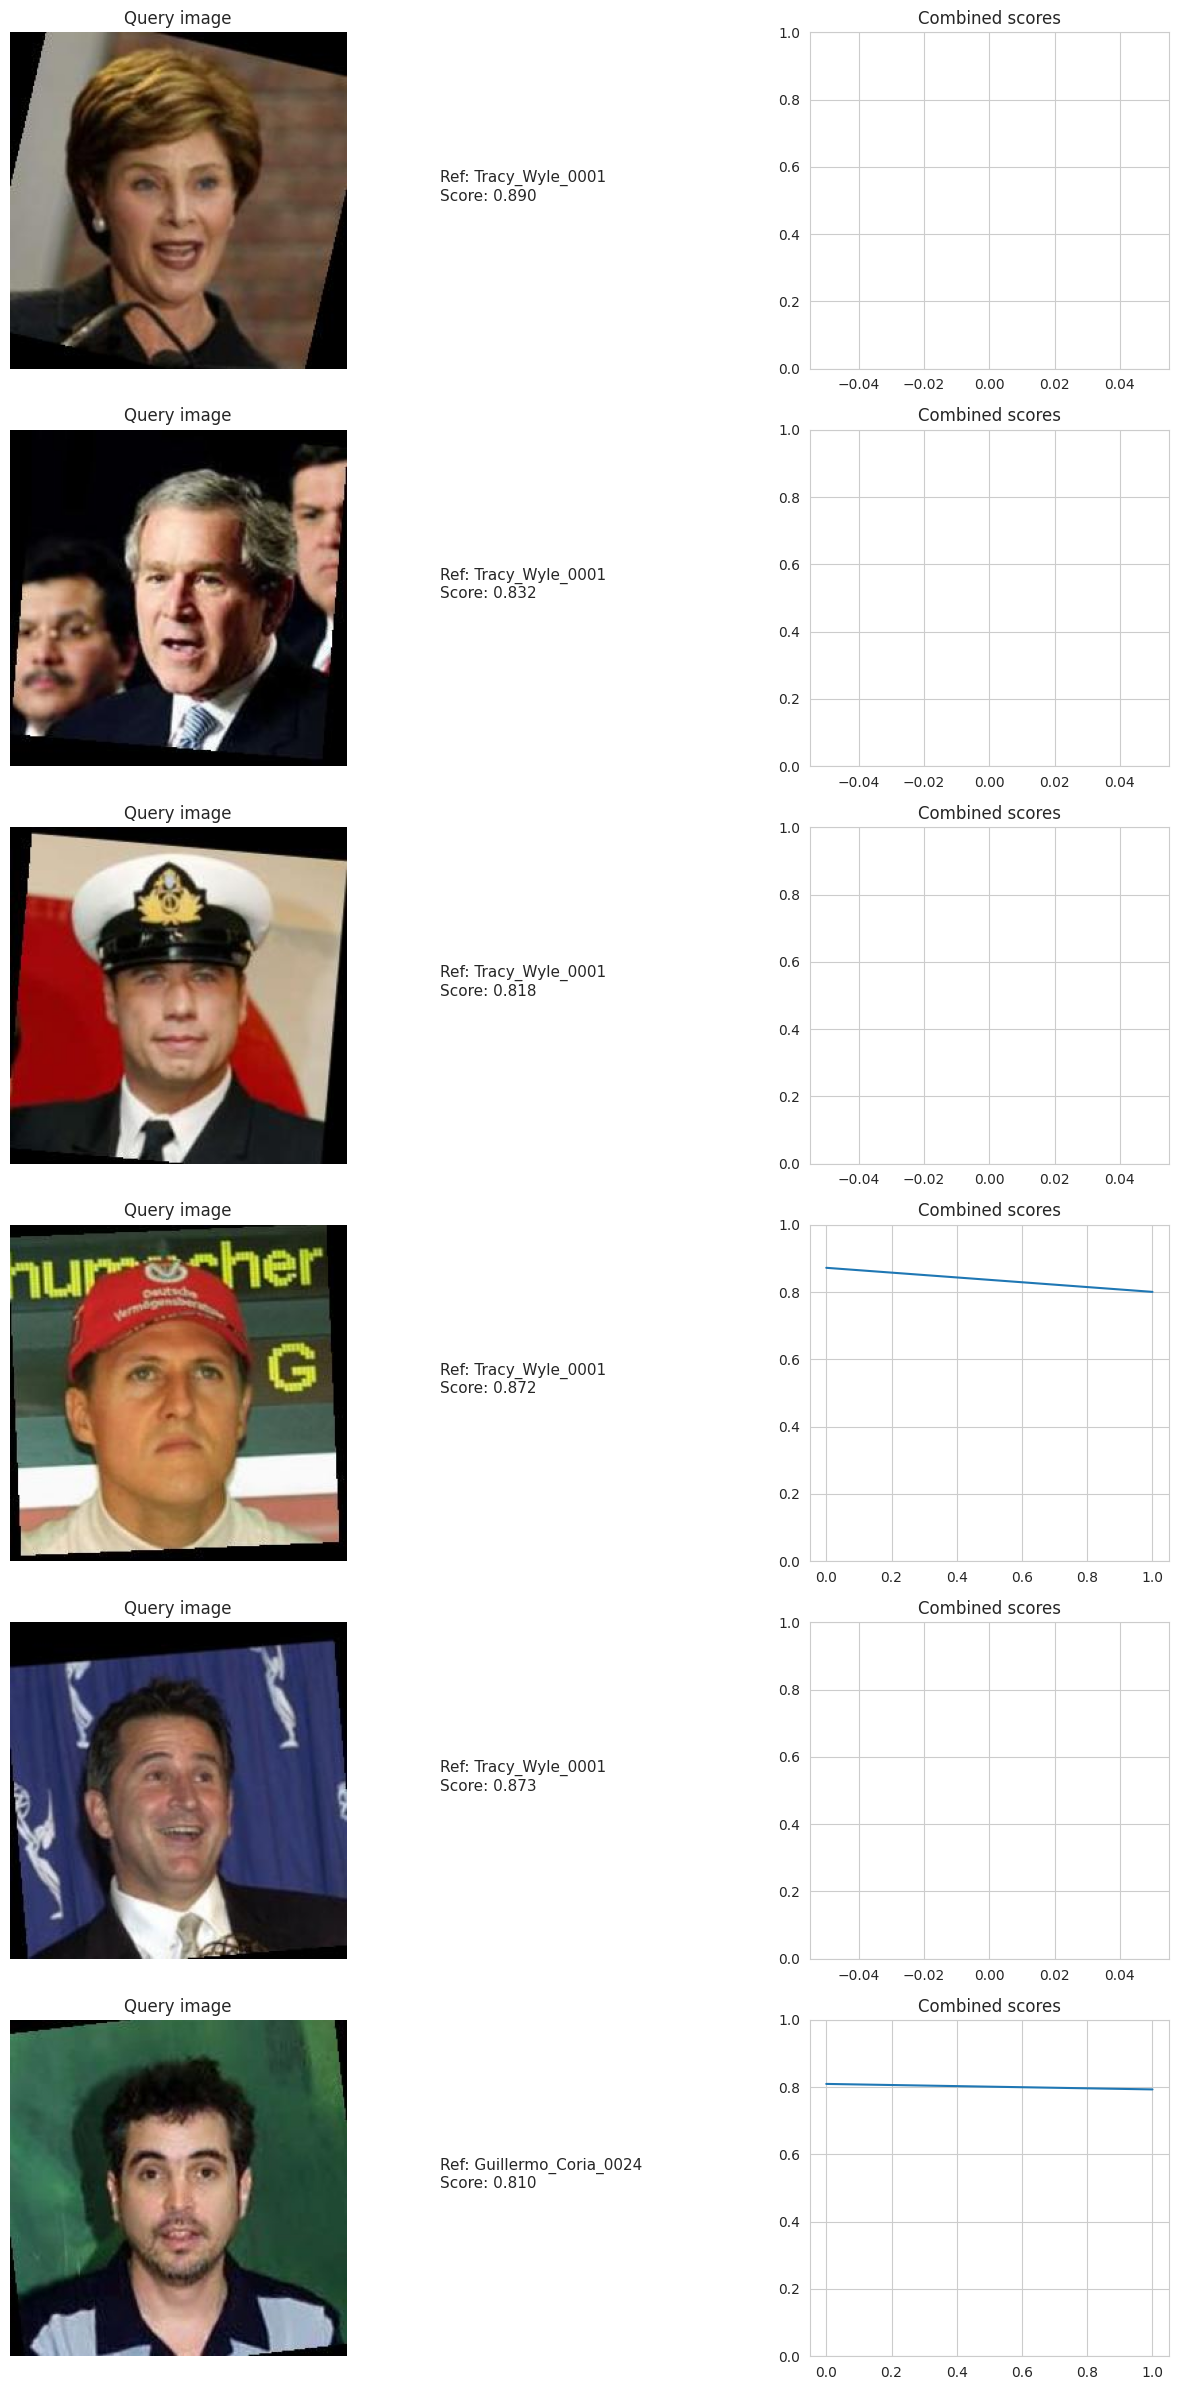

In [14]:
def show_matches(results: List[dict], count: int = 6):
    subset = [res for res in results if res.get('matches')]
    subset = subset[:count]
    if not subset:
        print('No matches to visualise')
        return
    fig, axes = plt.subplots(len(subset), 3, figsize=(12, 4 * len(subset)))
    if len(subset) == 1:
        axes = axes.reshape(1, -1)
    for row, res in enumerate(subset):
        img = res.get('input_image')
        axes[row, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[row, 0].set_title('Query image')
        axes[row, 0].axis('off')
        best = res['matches'][0]
        ref_id = best['application_id']
        ref_meta = pipeline.applications.get(ref_id, {})
        axes[row, 1].text(0.1, 0.5, f"Ref: {ref_meta.get('name', ref_id)}\nScore: {best['combined']:.3f}", fontsize=11)
        axes[row, 1].axis('off')
        axes[row, 2].plot([m['combined'] for m in res['matches']])
        axes[row, 2].set_ylim(0, 1)
        axes[row, 2].set_title('Combined scores')
    plt.tight_layout()

for app, res in zip(applications, results):
    res['input_image'] = app['image']

show_matches(results)


## 14. Highlight Duplicate Pairs


In [15]:
duplicate_pairs = []
for res in results:
    if res.get('status') == 'DUPLICATE' and res.get('matches'):
        duplicate_pairs.append((res['input_image'], res['matches'][0]))

print(f"Identified {len(duplicate_pairs)} duplicate-labelled applications")


Identified 38 duplicate-labelled applications


## 15. Bulk Duplicate Mining on LFW


Bulk mining from /home/snipl/Documents/Prototypes/IndiaAI/IndiaAI_De-Duplication/lfw_dataset/lfw-deepfunneled/lfw-deepfunneled


Loaded 400 faces
#01 Alejandro_Toledo/Alejandro_Toledo_0036.jpg <-> Alejandro_Toledo/Alejandro_Toledo_0037.jpg | euclidean=0.1762


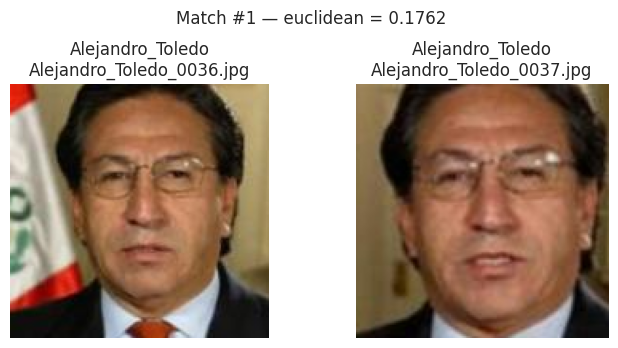

#02 Abdullah_Gul/Abdullah_Gul_0008.jpg <-> Abdullah_Gul/Abdullah_Gul_0010.jpg | euclidean=0.2055


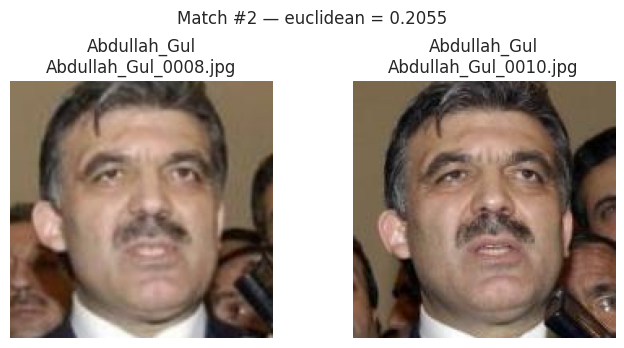

#03 Abdullah_Gul/Abdullah_Gul_0002.jpg <-> Abdullah_Gul/Abdullah_Gul_0004.jpg | euclidean=0.2250


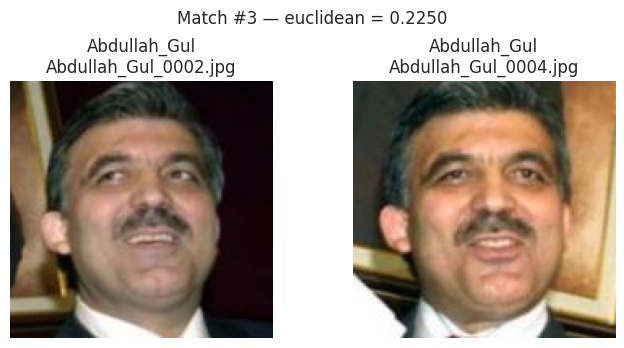

#04 Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg <-> Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0002.jpg | euclidean=0.2290


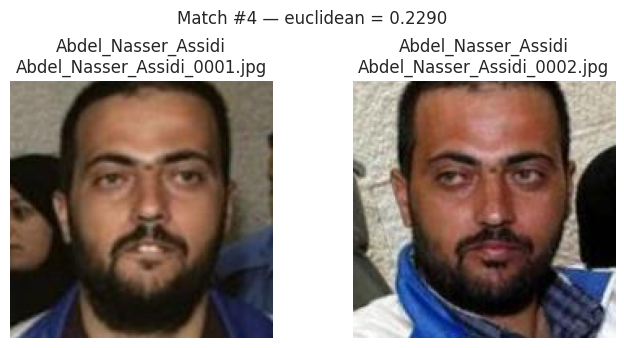

#05 Akhmed_Zakayev/Akhmed_Zakayev_0001.jpg <-> Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg | euclidean=0.2385


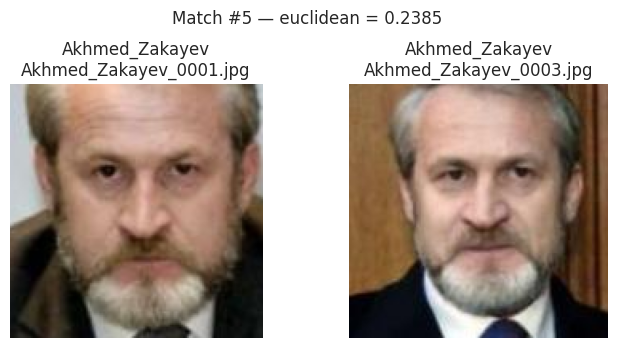

#06 Abdullah_Gul/Abdullah_Gul_0012.jpg <-> Abdullah_Gul/Abdullah_Gul_0013.jpg | euclidean=0.2463


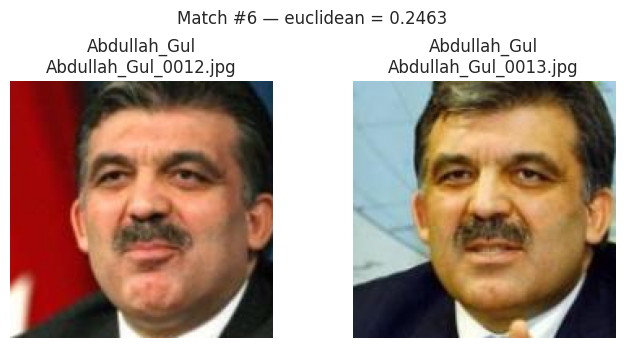

#07 Abel_Pacheco/Abel_Pacheco_0002.jpg <-> Abel_Pacheco/Abel_Pacheco_0003.jpg | euclidean=0.2466


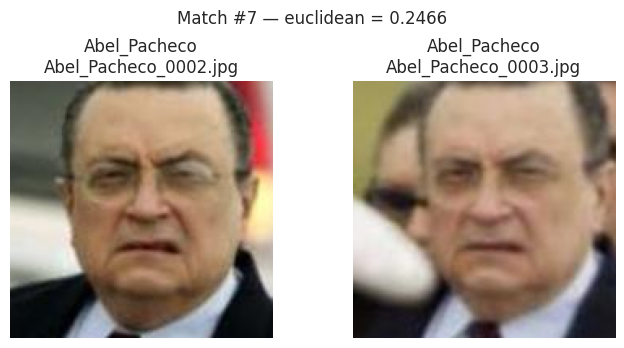

#08 Abdullah_Gul/Abdullah_Gul_0004.jpg <-> Abdullah_Gul/Abdullah_Gul_0012.jpg | euclidean=0.2471


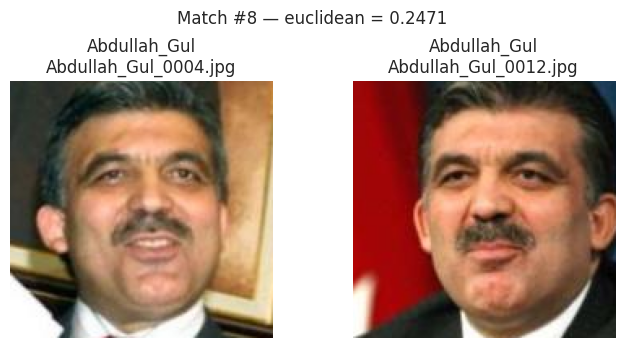

#09 Alice_Fisher/Alice_Fisher_0001.jpg <-> Alice_Fisher/Alice_Fisher_0002.jpg | euclidean=0.2559


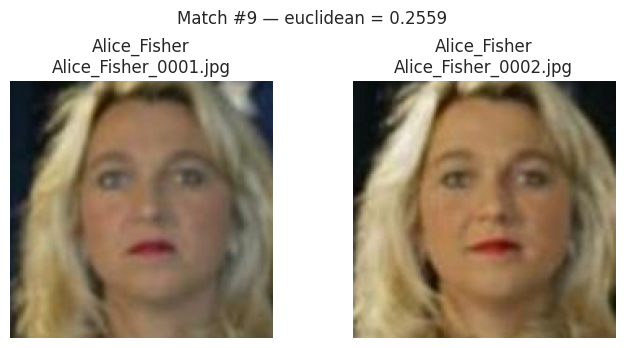

#10 Alejandro_Toledo/Alejandro_Toledo_0002.jpg <-> Alejandro_Toledo/Alejandro_Toledo_0034.jpg | euclidean=0.2569


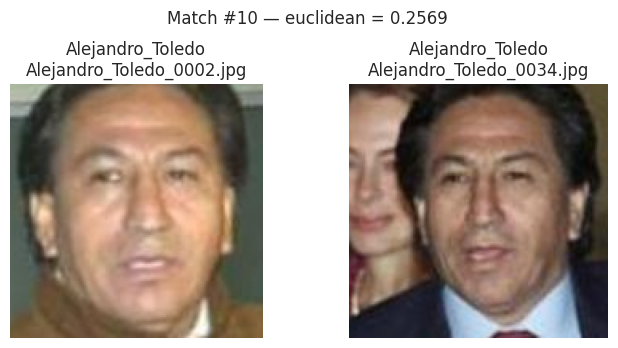

#11 Ai_Sugiyama/Ai_Sugiyama_0002.jpg <-> Ai_Sugiyama/Ai_Sugiyama_0003.jpg | euclidean=0.2581


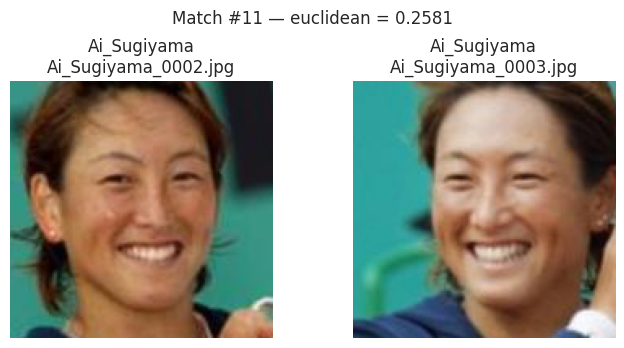

#12 Abdullah_Gul/Abdullah_Gul_0002.jpg <-> Abdullah_Gul/Abdullah_Gul_0010.jpg | euclidean=0.2688


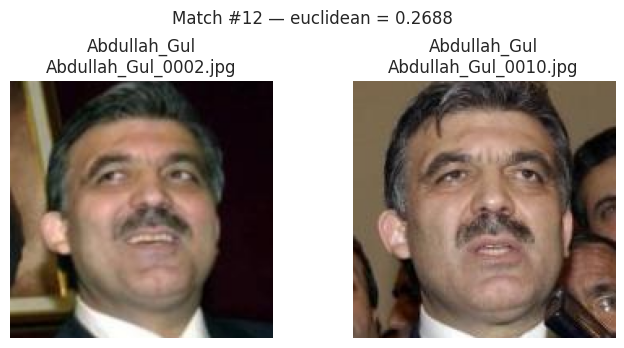

In [16]:
from dataclasses import dataclass

@dataclass
class FaceRecord:
    person_id: str
    image_path: Path
    face_location: Tuple[int, int, int, int]
    encoding: np.ndarray


def resolve_dataset_path(dataset_root: Path | str) -> Path:
    path = Path(dataset_root).expanduser().resolve()
    candidate = path / 'lfw-deepfunneled'
    nested = candidate / 'lfw-deepfunneled'
    if nested.is_dir():
        return nested
    if candidate.is_dir():
        return candidate
    return path


def load_face_records(dataset_root: Path | str, limit_per_identity: Optional[int] = None, max_total_images: Optional[int] = None) -> List[FaceRecord]:
    root = resolve_dataset_path(dataset_root)
    records: List[FaceRecord] = []
    processed = 0
    for person_dir in sorted(root.iterdir()):
        if not person_dir.is_dir():
            continue
        count = 0
        for image_path in sorted(person_dir.glob('*.jpg')):
            image = face_recognition.load_image_file(image_path)
            boxes = face_recognition.face_locations(image, model='hog')
            if not boxes:
                continue
            encs = face_recognition.face_encodings(image, boxes)
            for loc, enc in zip(boxes, encs):
                records.append(FaceRecord(person_dir.name, Path(image_path), loc, enc.astype(np.float32)))
                processed += 1
                count += 1
                if max_total_images and processed >= max_total_images:
                    return records
                if limit_per_identity and count >= limit_per_identity:
                    break
        if max_total_images and processed >= max_total_images:
            break
    return records


def compute_pair_scores(records: List[FaceRecord], metric: str = 'euclidean') -> List[Tuple[int, int, float]]:
    if len(records) < 2:
        return []
    encs = np.stack([r.encoding for r in records], axis=0)
    pairs: List[Tuple[int, int, float]] = []
    if metric == 'euclidean':
        for i in range(len(records) - 1):
            diff = encs[i + 1:] - encs[i]
            dists = np.linalg.norm(diff, axis=1)
            for j, dist in enumerate(dists, start=i + 1):
                pairs.append((i, j, float(dist)))
    else:
        sims = cosine_similarity(encs)
        for i in range(len(records) - 1):
            for j in range(i + 1, len(records)):
                pairs.append((i, j, float(sims[i, j])))
    return pairs


def find_duplicate_pairs(records: List[FaceRecord], threshold: float, metric: str, top_k: int) -> List[Tuple[FaceRecord, FaceRecord, float]]:
    pairs = compute_pair_scores(records, metric)
    if metric == 'euclidean':
        filtered = [(records[i], records[j], score) for i, j, score in pairs if score <= threshold]
        filtered.sort(key=lambda t: t[2])
    else:
        filtered = [(records[i], records[j], score) for i, j, score in pairs if score >= threshold]
        filtered.sort(key=lambda t: t[2], reverse=True)
    if not filtered:
        reverse = metric != 'euclidean'
        pairs.sort(key=lambda t: t[2], reverse=reverse)
        filtered = [(records[i], records[j], score) for i, j, score in pairs[:top_k]]
        print(f'No pairs within threshold; showing top {len(filtered)} pairs instead.')
    return filtered[:top_k]


def crop_face(image_path: Path, loc: Tuple[int, int, int, int], padding: float = 0.25) -> Image.Image:
    image = Image.open(image_path).convert('RGB')
    top, right, bottom, left = loc
    h = bottom - top
    w = right - left
    pad_h = int(h * padding)
    pad_w = int(w * padding)
    left = max(0, left - pad_w)
    top = max(0, top - pad_h)
    right = min(image.width, right + pad_w)
    bottom = min(image.height, bottom + pad_h)
    return image.crop((left, top, right, bottom))


def plot_duplicate_pair(record_a: FaceRecord, record_b: FaceRecord, score: float, metric: str, index: int, save_dir: Optional[Path] = None, show: bool = True):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
    axes[0].imshow(crop_face(record_a.image_path, record_a.face_location))
    axes[0].axis('off')
    axes[0].set_title(f'{record_a.person_id}\n{record_a.image_path.name}')
    axes[1].imshow(crop_face(record_b.image_path, record_b.face_location))
    axes[1].axis('off')
    axes[1].set_title(f'{record_b.person_id}\n{record_b.image_path.name}')
    fig.suptitle(f'Match #{index} — {metric} = {score:.4f}')
    fig.tight_layout()
    if save_dir:
        save_dir.mkdir(parents=True, exist_ok=True)
        out_path = save_dir / f'match_{index:02d}_{record_a.person_id}_{record_b.person_id}.png'
        fig.savefig(out_path, dpi=150, bbox_inches='tight')
        print(f'Saved {out_path}')
    if show:
        plt.show()
    else:
        plt.close(fig)

IMAGE_FOLDER = Path('lfw_dataset')
THRESHOLD = 0.55
METRIC = 'euclidean'
TOP_K = 12
MAX_IMAGES_PER_IDENTITY = 5
MAX_TOTAL_IMAGES = 400
SAVE_DIR = None
SHOW_PLOTS = True

resolved = resolve_dataset_path(IMAGE_FOLDER)
print(f'Bulk mining from {resolved}')
records = load_face_records(resolved, limit_per_identity=MAX_IMAGES_PER_IDENTITY, max_total_images=MAX_TOTAL_IMAGES)
print(f'Loaded {len(records)} faces')
if records:
    matches = find_duplicate_pairs(records, threshold=THRESHOLD, metric=METRIC, top_k=TOP_K)
    if not matches:
        print('No matches available at chosen settings.')
    else:
        for idx, (a, b, score) in enumerate(matches, start=1):
            print(f"#{idx:02d} {a.person_id}/{a.image_path.name} <-> {b.person_id}/{b.image_path.name} | {METRIC}={score:.4f}")
            plot_duplicate_pair(a, b, score, METRIC, idx, SAVE_DIR, SHOW_PLOTS)
else:
    print('No face encodings generated; adjust dataset path or limits.')
